In [1]:
%%time

import nibabel as nib
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
%matplotlib inline

import dmipy.data.saved_acquisition_schemes as saved_acquisition_schemes

from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel
from dmipy.core.fitted_modeling_framework import FittedMultiCompartmentModel

from dipy.viz import window, actor

import tqdm

import warnings
warnings.filterwarnings("ignore")

Wall time: 10.2 s


In [2]:
import numba
import pathos

In [3]:
data_hcp = nib.load('wu_minn_hcp_coronal_slice.nii.gz').get_data()
scheme_hcp = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

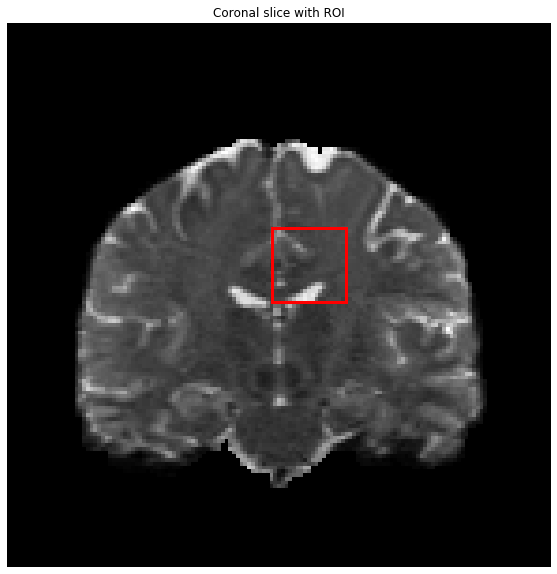

In [4]:
roi = {'x': 70, 'y': 70, 'width': 20, 'height': 20}
data_hcp_roi = data_hcp[
    roi['x'] : roi['x'] + roi['width'], :, roi['y'] : roi['y'] + roi['height']
]

fig, ax = plt.subplots(figsize=[10, 10])
ax.imshow(data_hcp[:, 0, :, 0].T, origin='lower', cmap='gray', interpolation='nearest')

rect = patches.Rectangle(
    (roi['x'], roi['y']), roi['width'], roi['height'], 
    linewidth = 3, edgecolor = 'r', facecolor = 'none'
)
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('Coronal slice with ROI');

In [5]:
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

In [6]:
def set_parameters(our_voxel_bas_model, scheme_hcp, voxel_signal):
    params = []

    # estimate S0
    our_voxel_bas_model.scheme = scheme_hcp
    S0 = np.mean(voxel_signal[scheme_hcp.b0_mask], axis=-1)
    
    # G1Ball_1_lambda_iso
    param_range = our_voxel_bas_model.parameter_ranges['G1Ball_1_lambda_iso']
    lambda_iso = np.random.uniform(param_range[0], param_range[1]) * 1e-09

    # C1Stick_1_mu
    param_ranges = our_voxel_bas_model.parameter_ranges['C1Stick_1_mu']
    mu_1 = np.random.uniform(param_ranges[0][0], param_ranges[0][1])
    mu_2 = np.random.uniform(param_ranges[1][0], param_ranges[1][1])
    
    # C1Stick_1_lambda_par
    param_range = our_voxel_bas_model.parameter_ranges['C1Stick_1_lambda_par']
    lambda_parallel = np.random.uniform(param_range[0], param_range[1]) * 1e-09
    
    # partial_volume_0
    param_range = our_voxel_bas_model.parameter_ranges['partial_volume_0']
    f_stick = np.random.uniform(param_range[0], param_range[1])
    
    # partial_volume_1
    param_range = our_voxel_bas_model.parameter_ranges['partial_volume_1']
    f_ball = np.random.uniform(param_range[0], param_range[1])
            
    return FittedMultiCompartmentModel(
        our_voxel_bas_model, np.array(S0), np.array([True]), 
        np.array([[mu_1, mu_2, lambda_iso, lambda_parallel, f_stick, f_ball]])
    )

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in range(roi['width']):
    our_bas_model[x] = {}
    for y in range(roi['height']):
        
        voxel_signal = data_hcp_roi[x, 0, y, :]
        our_bas_model[x][y] = set_parameters(bas_model, scheme_hcp, voxel_signal)
        
        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)
          
print("Fitting accuracy:")        
print("MSE +/- STD = %f +/- %f" % (np.mean(voxel_mse), np.std(voxel_mse)))

Fitting accuracy:
MSE +/- STD = 0.105955 +/- 0.111695


our randomized model:


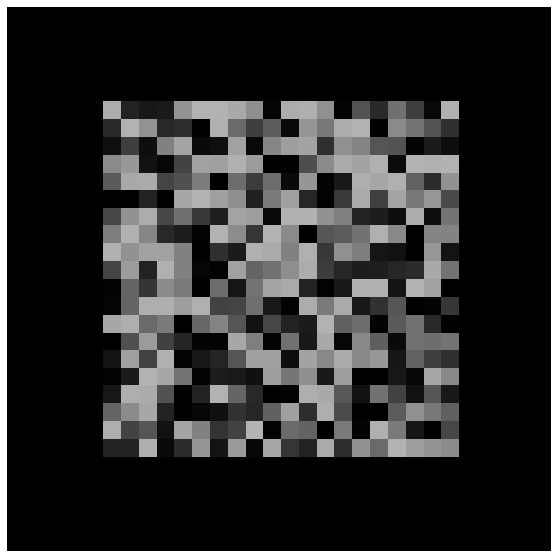

In [7]:
def visualize_result(bas_models_fit):

    affine = np.eye(4)
    affine[0,3] = -10
    affine[1,3] = -10

    volume = np.zeros([roi['width'], roi['height'], 1])
    peak_dirs = np.zeros([roi['width'], roi['height'], 1, 1, 3])

    for x in range(roi['width']):
        for y in range(roi['height']):
            volume[x, y, 0] = bas_models_fit[x][y].fitted_parameters['partial_volume_0']
            peak_cart = np.squeeze(bas_models_fit[x][y].peaks_cartesian())
            peak_dirs[x, y, 0] = [peak_cart[0], peak_cart[2], -peak_cart[1]]

    ren = window.ren()
    ren.add(actor.slicer(volume, interpolation='nearest', affine=affine, opacity=0.7))
    ren.add(actor.peak_slicer(peak_dirs, None, affine=affine, linewidth=5, colors=None))   

    window.record(ren, size=[700, 700], out_path='dipy.png')
    
    img = mpimg.imread('dipy.png')
    plt.figure(figsize=[10, 10])
    plt.imshow(img) #[100:-97, 100:-85])
    plt.axis('off');
    
print("our randomized model:")
visualize_result(our_bas_model)

# ES

In [8]:
def es_for_single_voxel(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1, R=None,mutation_type="3"):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 1e10

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    
    def mut1(og):
        return og + sigma * np.random.randn(number_of_offspring, chromosome_length)
    
    def mut2(og):
        S = np.random.uniform(0,sigma, chromosome_length)
        return og + S * np.random.randn(number_of_offspring, chromosome_length)
    
    def mut3(og):
        S = np.random.uniform(0,sigma, size=(chromosome_length, chromosome_length))
        S = np.dot(S,S.T)
        return og + np.dot(np.random.randn(number_of_offspring, chromosome_length), np.linalg.cholesky(S).T)
    
    # mutation function
    if mutation_type == "1":
        mutation_f = mut1
    elif mutation_type == "2":
        mutation_f = mut2
    elif mutation_type == "3":
        mutation_f = mut3
    else:
        print("Wrong mutation function!")
    
    def in_domain(chrom, R):
        for p in range(len(chrom)):
            if not R[p][0] < chrom[p] < R[p][1]:
                chrom[p] = np.random.uniform(R[p][0],R[p][1])
        return chrom
    
    def initial_population(population_size, R):
        current_population_solutions = np.zeros((population_size, chromosome_length))
        for pop in range(population_size):
            for p in range(chromosome_length):
                current_population_solutions[pop][p] = np.random.uniform(R[p][0],R[p][1])
        return current_population_solutions

    # generating an initial population
    current_population_solutions = initial_population(population_size, R)

    # evaluating the objective function on the current population
    current_population_objective_values = np.zeros(population_size)
    for i, guy in enumerate(current_population_solutions):
            current_population_objective_values[i] = objective_function(guy)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_solutions = mutation_f(children_population_solutions)
        
        # check if in domain
        for chrom in children_population_solutions:
            chrom = in_domain(chrom, R)                
        
        # evaluating the objective function on the children population
        children_population_objective_values = np.zeros(len(children_population_solutions))
        for i, child in enumerate(children_population_solutions):
            children_population_objective_values[i] = objective_function(child)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])

        I = np.argsort(-current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value > current_population_objective_values[0]:
            best_solution = current_population_solutions[0]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        
        if log_frequency != -1 and np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 0].min(), log_objective_values[t, 2]))
    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions

In [9]:
def set_params_from_chrom(chrom, our_voxel_bas_model, scheme_hcp, voxel_signal):
    our_voxel_bas_model.scheme = scheme_hcp
    S0 = np.mean(voxel_signal[scheme_hcp.b0_mask], axis=-1)
    
    mu_1, mu_2 = chrom[0], chrom[1]
    lambda_parallel = chrom[2] * 1e-09
    lambda_iso = chrom[3] * 1e-09
    f_stick = chrom[4]
    f_ball = chrom[5]
    
    return FittedMultiCompartmentModel(
            our_voxel_bas_model, np.array(S0), np.array([True]), 
            np.array([[mu_1, mu_2, lambda_iso, lambda_parallel, f_stick, f_ball]])
    )


def single_voxel_function(chromosome, bas_model, scheme_hcp, voxel_signal):
    '''
    dla danego chromosomu o dl. 6 wypluwa jego MSE
    '''
    model = set_params_from_chrom(chromosome, bas_model, scheme_hcp, voxel_signal)
    return model.mean_squared_error(voxel_signal)

def domain_dict_to_array(d):
    domains_dict = d
    domains_list = np.array(list(domains_dict.values()))
    domains_array = np.array(domains_list[0][0])
    domains_array = np.vstack((domains_array, domains_list[0][1]))
    domains_array = np.vstack((domains_array, domains_list[1]))
    domains_array = np.vstack((domains_array, domains_list[2]))
    domains_array = np.vstack((domains_array, domains_list[3]))
    domains_array = np.vstack((domains_array, domains_list[4]))
    return domains_array


In [10]:
def set_random_parameters(our_voxel_bas_model, scheme_hcp, voxel_signal):
    params = []

    # estimate S0
    our_voxel_bas_model.scheme = scheme_hcp
    S0 = np.mean(voxel_signal[scheme_hcp.b0_mask], axis=-1)
    
    # G1Ball_1_lambda_iso
    param_range = our_voxel_bas_model.parameter_ranges['G1Ball_1_lambda_iso']
    lambda_iso = np.random.uniform(param_range[0], param_range[1]) * 1e-09

    # C1Stick_1_mu
    param_ranges = our_voxel_bas_model.parameter_ranges['C1Stick_1_mu']
    mu_1 = np.random.uniform(param_ranges[0][0], param_ranges[0][1])
    mu_2 = np.random.uniform(param_ranges[1][0], param_ranges[1][1])
    
    # C1Stick_1_lambda_par
    param_range = our_voxel_bas_model.parameter_ranges['C1Stick_1_lambda_par']
    lambda_parallel = np.random.uniform(param_range[0], param_range[1]) * 1e-09
    
    # partial_volume_0
    param_range = our_voxel_bas_model.parameter_ranges['partial_volume_0']
    f_stick = np.random.uniform(param_range[0], param_range[1])
    
    # partial_volume_1
    param_range = our_voxel_bas_model.parameter_ranges['partial_volume_1']
    f_ball = np.random.uniform(param_range[0], param_range[1])
            
    return FittedMultiCompartmentModel(
        our_voxel_bas_model, np.array(S0), np.array([True]), 
        np.array([[mu_1, mu_2, lambda_iso, lambda_parallel, f_stick, f_ball]])
    )


def set_params_from_chrom(chrom, our_voxel_bas_model, scheme_hcp, voxel_signal):
    our_voxel_bas_model.scheme = scheme_hcp
    S0 = np.mean(voxel_signal[scheme_hcp.b0_mask], axis=-1)
    
    mu_1, mu_2 = chrom[0], chrom[1]
    lambda_parallel = chrom[2] * 1e-09
    lambda_iso = chrom[3] * 1e-09
    f_stick = chrom[4]
    f_ball = chrom[5]
    
    return FittedMultiCompartmentModel(
            our_voxel_bas_model, np.array(S0), np.array([True]), 
            np.array([[mu_1, mu_2, lambda_iso, lambda_parallel, f_stick, f_ball]])
    )

def objective_function(ch, bas_model, scheme_hcp, voxel_signal):
    new_chroms = ch.reshape((roi['width'], roi['height'], 6))
    
    our_bas_model = {}
    voxel_mse = np.zeros([roi['width'], roi['height']])

    for x in range(roi['width']):
        our_bas_model[x] = {}
        for y in range(roi['height']):

            voxel_signal = data_hcp_roi[x, 0, y, :]
            our_bas_model[x][y] = set_params_from_chrom(new_chroms[x][y], bas_model, scheme_hcp, voxel_signal)

            voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

    return np.mean(voxel_mse)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:58<00:00, 11.92s/it]



Final MSE: 0.003639859591010608 and STD: 0.0017119811951108216
Wall time: 4min


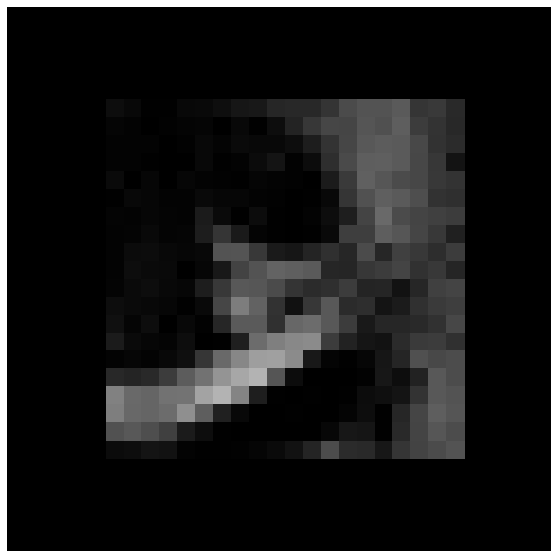

In [18]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 50
T = 30

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        best_value, best_chromosome, _, _ = es_for_single_voxel(lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                                         d, N, T, 3*N, 2, 0.2, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),
                                                         -1, R=domain_dict_to_array(bas_model.parameter_ranges), mutation_type="1")

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:05<00:00, 12.27s/it]



Final MSE: 0.0034733794415457053 and STD: 0.0016376888439249304
Wall time: 4min 7s


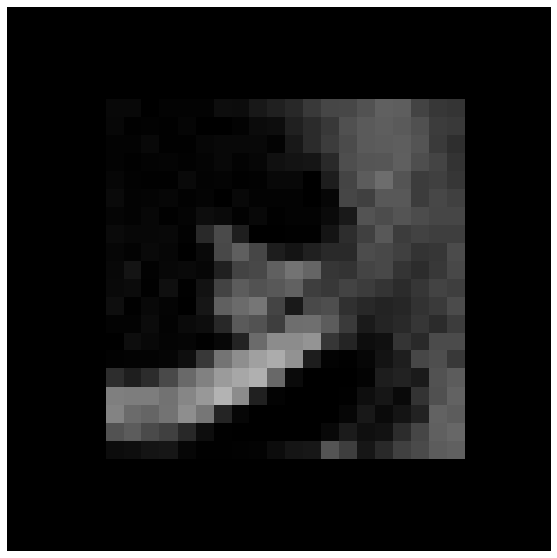

In [19]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 50
T = 30

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        best_value, best_chromosome, _, _ = es_for_single_voxel(lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                                         d, N, T, 3*N, 2, 0.2, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),
                                                         -1, R=domain_dict_to_array(bas_model.parameter_ranges), mutation_type="2")

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.18s/it]



Final MSE: 0.0038204755721520252 and STD: 0.0016774839258166727
Wall time: 4min 5s


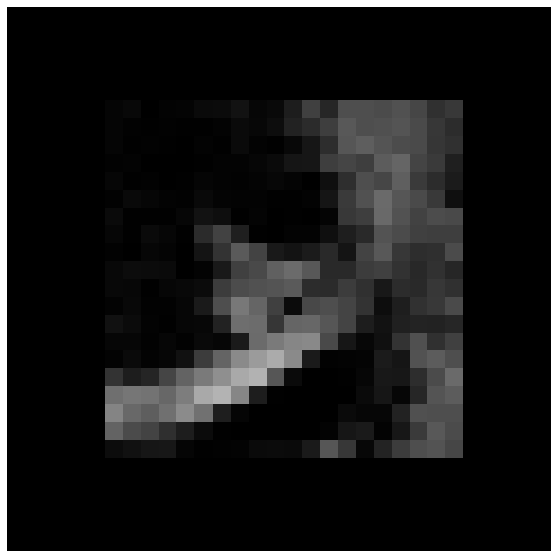

In [20]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 50
T = 30

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        best_value, best_chromosome, _, _ = es_for_single_voxel(lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                                         d, N, T, 3*N, 2, 0.2, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),
                                                         -1, R=domain_dict_to_array(bas_model.parameter_ranges), mutation_type="3")
#         print(f'Best MSE of voxel x={x},y={y} is {np.round(best_value,4)}')

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

In [84]:
class ES():
    def __init__(self, R, d, mi, lambda_, F, max_iter=100,learning_rate=0.01,debug=False, ES_type="+",mutation_type="0"):
        self.R = R
        self.d = d
        self.mi = mi # offspring
        self.lambda_ = lambda_ # parents
        self.F = F
        self.current_population = []
        self.current_values = []
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tau0 = learning_rate/np.sqrt(2*np.sqrt(d))
        self.tau = learning_rate/np.sqrt(2*d)
        self.debug = debug
        
        if mutation_type == "0":
            self.mutation = self.mutation0
        if mutation_type == "1":
            self.mutation = self.mutation1
        if mutation_type == "2":
            self.mutation = self.mutation2
        if mutation_type == "3":
            self.mutation = self.mutation3
        if mutation_type == "4":
            self.mutation = self.mutation4
        
        if ES_type == "+":
            self.es_type = '+'
        elif ES_type == ",":
            self.es_type = ','
        else:
            print("Wrong ES type. Try '+' or ','")
        
        self.results = np.array([(0,0,0)])
    
    def in_domain(self, chrom):
        for p in range(len(chrom)):
            if not self.R[p][0] < chrom[p] < self.R[p][1]:
                chrom[p] = np.random.uniform(self.R[p][0],self.R[p][1])
        return chrom
        
    def check_if_in_domain(self, chrom):
        for p in range(len(chrom)):
            if not self.R[p][0] < chrom[p] < self.R[p][1]:
                return False
        return True
    
    def plot_values(self):
        plt.figure()
        plt.plot(self.results.T[1].T,color='green',label='min')
        plt.plot(self.results.T[0].T,color='blue',label='mean')
        plt.plot(self.results.T[2].T,color='red',label='max')
        plt.legend()
        plt.show()
        
    def random_population(self):
        # arg: self.mi
        # osobnik: x1,...,xd, s1,...,sd
        self.current_population = np.zeros((self.mi, 2, self.d))
        for pop in range(self.mi):
            for p in range(self.d):
                self.current_population[pop][0][p] = np.random.uniform(self.R[p][0],self.R[p][1])
                self.current_population[pop][1][p] = np.random.uniform(self.R[p][0],self.R[p][1])
        self.current_values = np.zeros((self.mi, 1))
    
    def population_evaluation(self):
        # arg: self.current_population, self.F
        for i,sb in enumerate(self.current_population):
            self.current_values[i] = self.F(sb[0])
    
    def parent_selection(self):
        # arg: self.current_population, self.lambda_
        
        # roulette method
        costs = np.array([self.F(i[0]) for i in self.current_population])
        costs = costs.reshape(-1)
        fitness_values = costs - costs.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / self.mi * np.ones(self.mi)
        parent_indices = np.random.choice(len(self.current_population), size=len(self.current_population), replace=True,p=fitness_values).astype(np.int64)
        return self.current_population[parent_indices]
    
    def mutation0(self, pc):
        # sprawdz czy miesci sie w dziedzinie
        pcc = pc.copy()
        for sb in range(len(pc)):
            addition = np.exp(np.random.normal(0, self.tau ** 2, size=len(pc[sb][1])) + np.random.normal(0, self.tau0 ** 2))
            # taus
            pcc[sb][1] *= addition
            los = pcc[sb][0] + np.random.normal(0, pcc[sb][1] ** 2,size=self.d)
            # jesli ciagle poza dziedzina
            los = self.in_domain(los)
            pcc[sb][0] = los
        return pcc
    
    def mutation1(self, pc):
        for sb in range(len(pc)):
            sigma = 0.25
            pc[sb][0] += sigma * np.random.randn(self.d)
            pc[sb][0] = self.in_domain(pc[sb][0])
        return pc
    
    def mutation2(self, pc):
        sigma = 0.25
        S = np.random.uniform(0, sigma, self.d)
        for sb in range(len(pc)):
            pc[sb][0] += S * np.random.randn(self.d)
            pc[sb][0] = self.in_domain(pc[sb][0])
        return pc
    
    def mutation3(self, pc):
        sigma = 0.25
        S = np.random.uniform(0,sigma, size=(self.d, self.d))
        S = np.dot(S,S.T)
        b = np.dot(np.random.randn(self.mi, self.d), np.linalg.cholesky(S).T)
        
        for sb in range(len(pc)):
            pc[sb][0] += b[sb]
            pc[sb][0] = self.in_domain(pc[sb][0])
        return pc
    
    def mutation4(self, pc):
        # sprawdz czy miesci sie w dziedzinie
        pcc = pc.copy()
        for sb in range(len(pc)):
            addition = np.exp(np.random.normal(0, self.tau ** 2, size=len(pc[sb][1])) + np.random.normal(0, self.tau0 ** 2))
            # taus
            pcc[sb][1] *= addition
            
            los = pcc[sb][0] + np.random.normal(0, pcc[sb][1] ** 2,size=self.d)
            for _ in range(3):
                if self.check_if_in_domain(los):
                    break
                los = pcc[sb][0] + np.random.normal(0, pcc[sb][1] ** 2,size=self.d)
                
            # jesli ciagle poza dziedzina
            los = self.in_domain(los)
            pcc[sb][0] = los
        return pcc
    
    def replacement(self, pc):
        # tu bedziemy zmieniac self.current_population
        if self.es_type == ",":
            random_indices = np.random.choice(np.arange(0, len(pc)), size=len(self.current_population))
            self.current_population[random_indices] = pc[random_indices]
                
        elif self.es_type == "+":
            # wybierzmy najlepszych
            all_values = np.append(self.current_values, np.array([self.F(i[0]) for i in pc]))
            all_individuals = np.vstack((self.current_population, pc))
            best_pop_id = np.argsort(all_values)
            self.current_population = all_individuals[best_pop_id[:len(self.current_population)]]
        
    def run(self):
        self.random_population()
        self.population_evaluation()
        
        for i in range(self.max_iter):
            pc = self.parent_selection()
            pc = self.mutation(pc)
            self.replacement(pc)
            self.population_evaluation()
            self.results = np.vstack((self.results, (self.current_values.mean(), self.current_values.min(),self.current_values.max())))
            if self.debug and i%int(self.max_iter/10) == 0:
                print(self.current_values.mean(), self.current_values.min(),self.current_values.max())
        # tu zwrocic najlepszego osobnika z populacji
        self.results = self.results[1:]
        return self.current_population[np.argmin(self.current_values)]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:41<00:00,  8.08s/it]



Final MSE: 0.005455221185347054 and STD: 0.003208939828186717
Wall time: 2min 43s


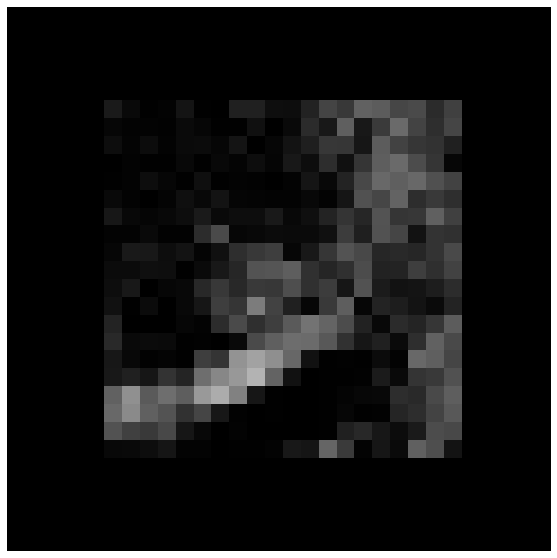

In [62]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 30
T = 30

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=0.2,debug=False, ES_type="+")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:43<00:00, 23.16s/it]



Final MSE: 0.004490899604099757 and STD: 0.002587459756361988
Wall time: 7min 44s


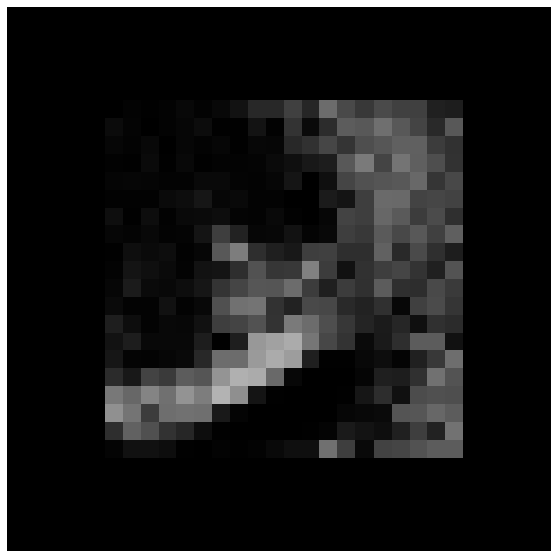

In [63]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 30
T = 30

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=3*N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=0.2,debug=False, ES_type="+")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [14:12<00:00, 42.63s/it]



Final MSE: 0.004077936665051293 and STD: 0.002308571470225758
Wall time: 14min 13s


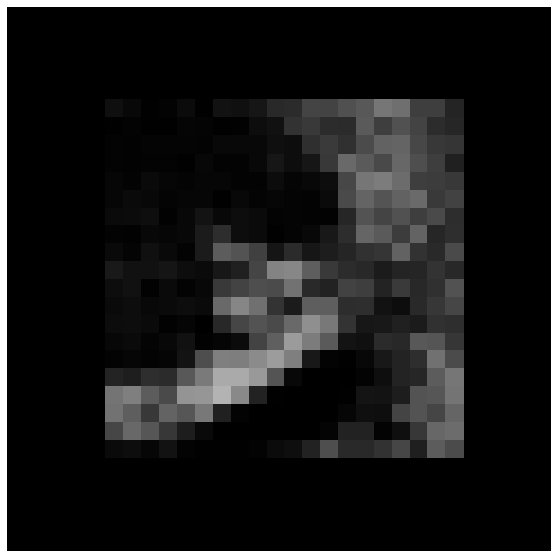

In [64]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 100
T = 50

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=0.2,debug=False, ES_type="+")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [06:01<00:00, 18.05s/it]



Final MSE: 0.004888984037008854 and STD: 0.0029173521268566383
Wall time: 6min 2s


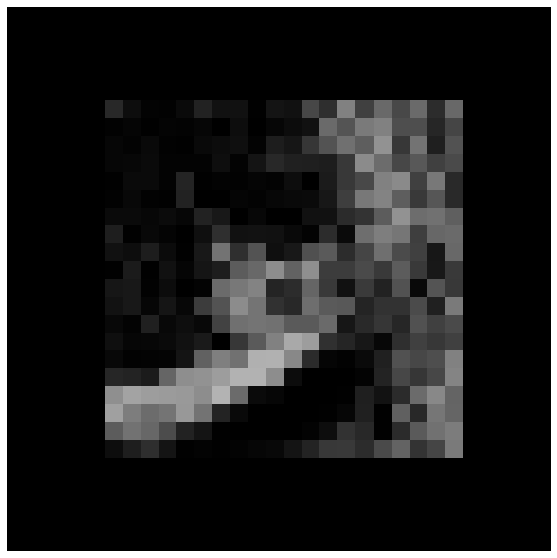

In [65]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 30
T = 30

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=2*N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=0.05,debug=False, ES_type="+")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

In [69]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 30
T = 30

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=2*N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=0.05,debug=False, ES_type="+")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:58<00:00, 14.94s/it]


Final MSE: 0.004818101664618652 and STD: 0.002736844766123639
Wall time: 4min 58s


In [79]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 30
T = 30

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=2*N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=0.05,debug=False, ES_type="+", mutation_type="1")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:40<00:00, 14.03s/it]


Final MSE: 0.004262452379051232 and STD: 0.0020617766348149597
Wall time: 4min 40s


In [81]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 30
T = 30

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=2*N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=0.05,debug=False, ES_type="+", mutation_type="2")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:38<00:00, 13.93s/it]


Final MSE: 0.003965303109202681 and STD: 0.0019854218964623907
Wall time: 4min 38s


In [85]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 30
T = 30

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=2*N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=0.05,debug=False, ES_type="+", mutation_type="3")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:26<00:00, 13.34s/it]


Final MSE: 0.004525849771626686 and STD: 0.0021502273789223937
Wall time: 4min 26s


In [86]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 30
T = 30

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=2*N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=0.05,debug=False, ES_type="+", mutation_type="4")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:15<00:00, 15.75s/it]


Final MSE: 0.004818152983653131 and STD: 0.002733061134727278
Wall time: 5min 15s


# TODO:
- CMA-ES
- inne obchodzenie się z osobikami spoza dziedziny
- mój ES można przyspieszyć

In [ ]:
# class CMA_ES():
#     def __init__(self, R, F, parents, offspring, max_iter=100):
#         self.d = 6
#         self.parents_size = parents # parents
#         self.offspring_size = offspring # offspring
#         self.sigma = 1 # 0.3 # step size
#         self.m = np.zeros(self.d)
#         self.C = np.zeros((self.d,self.d)) + 1
#         self.p_sigma = 0 # (isotropic evolution path)
#         self.p_C = 0 # (anisotropic evolution path)
#         self.F = F
#         self.max_iter = max_iter
        
#         self.R = R
#         self.current_population = []
#         self.current_values = []
    
#     def in_domain(self, chrom):
#         for p in range(len(chrom)):
#             if not self.R[p][0] < chrom[p] < self.R[p][1]:
#                 chrom[p] = np.random.uniform(self.R[p][0],self.R[p][1])
#         return chrom
        
#     def check_if_in_domain(self, chrom):
#         for p in range(len(chrom)):
#             if not self.R[p][0] < chrom[p] < self.R[p][1]:
#                 return False
#         return True
        
#     def random_population(self):
#         self.current_population = np.zeros((self.parents_size, 2, self.d))
#         for pop in range(self.parents_size):
#             for p in range(self.d):
#                 self.current_population[pop][0][p] = np.random.uniform(self.R[p][0],self.R[p][1])
#                 self.current_population[pop][1][p] = np.random.uniform(self.R[p][0],self.R[p][1])
#         self.current_values = np.zeros((self.parents_size, 1))
        
#     def new_population(self):
        
    
#     def population_evaluation(self):
#         # arg: self.current_population, self.F
#         for i,sb in enumerate(self.current_population):
#             self.current_values[i] = self.F(sb[0])
    
#     def parent_selection(self):        
#         # roulette method
#         costs = np.array([self.F(i[0]) for i in self.current_population])
#         costs = costs.reshape(-1)
#         fitness_values = costs - costs.min()
#         if fitness_values.sum() > 0:
#             fitness_values = fitness_values / fitness_values.sum()
#         else:
#             fitness_values = 1.0 / self.parents_size * np.ones(self.parents_size)
#         parent_indices = np.random.choice(len(self.current_population), size=len(self.current_population), replace=True,p=fitness_values).astype(np.int64)
#         return self.current_population[parent_indices]
    
#     def cumulative_step_size_adaptation(self):
#         pass
    
#     def covariance_matrix_adaptation(self):
#         pass
    
#     def mutation(self, pc):
#         for sb in range(len(pc)):
#             sigma = 0.25
#             pc[sb][0] += sigma * np.random.randn(self.d)
#             pc[sb][0] = self.in_domain(pc[sb][0])
#         return pc
    
#     def replacement(self, pc):
#         # wybierzmy najlepszych
#         all_values = np.append(self.current_values, np.array([self.F(i[0]) for i in pc]))
#         all_individuals = np.vstack((self.current_population, pc))
#         best_pop_id = np.argsort(all_values)
#         self.current_population = all_individuals[best_pop_id[:len(self.current_population)]]
        
#     def run(self):
#         self.random_population()
#         self.population_evaluation()
        
#         for i in range(self.max_iter):
#             self.cumulative_step_size_adaptation()

#             self.population_evaluation()
#         # tu zwrocic najlepszego osobnika z populacji
#         return self.current_population[np.argmin(self.current_values)]

In [38]:
class CMA_ES():
    def __init__(self, R, F, d, parents, offspring, max_iter=100):
        self.d = d
        self.parents_size = parents # parents
        self.offspring_size = offspring # offspring
        self.sigma = 1 # 0.3 # step size
        self.m = np.zeros(self.d)
        self.C = np.identity(self.d)
        self.p_sigma = 0 # (isotropic evolution path)
        self.p_C = 0 # (anisotropic evolution path)
        self.F = F
        self.max_iter = max_iter
        
        self.R = R
        self.current_population = []
        self.current_values = np.zeros((self.parents_size))
        
        self.previous_cost = 100
    
    def in_domain(self, chrom):
        for p in range(len(chrom)):
            if not self.R[p][0] < chrom[p] < self.R[p][1]:
                chrom[p] = np.random.uniform(self.R[p][0],self.R[p][1])
        return chrom
        
    def check_if_in_domain(self, chrom):
        for p in range(len(chrom)):
            if not self.R[p][0] < chrom[p] < self.R[p][1]:
                return False
        return True
        
    def random_population(self):
        self.current_population = np.zeros((self.parents_size, self.d))
        for pop in range(self.parents_size):
            self.current_population[pop] = np.random.multivariate_normal(self.m,self.sigma**2*self.C)
            assert len(self.current_population[pop]) == self.d
            self.in_domain(self.current_population[pop])
            
    def parent_selection(self):        
        # roulette method
        costs = self.current_values
        costs = costs.reshape(-1)
        fitness_values = costs - costs.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / self.parents_size * np.ones(self.parents_size)
        parent_indices = np.random.choice(len(self.current_population), size=self.offspring_size, replace=True,p=fitness_values).astype(np.int64)
        return self.current_population[parent_indices]
        
    
    def population_evaluation(self):
        # arg: self.current_population, self.F
        self.previous_cost = np.mean(self.current_values)
        better_counter = 0
        for i,sb in enumerate(self.current_population):
            self.current_values[i] = self.F(sb)
            if self.current_values[i] > self.previous_cost:
                better_counter += 1
        # 1/5th rule
        self.sigma = self.sigma * np.exp(1/3 * (better_counter/self.parents_size - 0.2)/(1 - 0.2))
    
    def cumulative_step_size_adaptation(self, pc):
        c_sigma = 4/self.d
        d_sigma = 0.99
        y = pc.mean(axis=0) # TODO srednia wazona
        assert len(y) == self.d
        self.m = self.m + self.sigma*y
        
        self.p_sigma = (1-c_sigma)*self.p_sigma + np.sqrt(1 - (1- c_sigma)**2)*y #np.sqrt()
        
        self.sigma = self.sigma*np.exp(c_sigma/d_sigma * np.linalg.norm(self.p_sigma)/np.mean(np.linalg.norm(np.random.multivariate_normal(np.zeros(self.d), np.identity(self.d)))))
    
    def covariance_matrix_adaptation(self, pc):
        c_cov = 2/self.d**2
        
        y = pc.mean(axis=0) # TODO srednia wazona
        assert len(y) == self.d
        self.m = self.m + self.sigma*y
        
        self.C = (1-c_cov) * self.C + c_cov*y*y.T
        
    def run(self):
        self.random_population()
        self.population_evaluation()
        
        for i in range(self.max_iter):
            pc = self.parent_selection()
            self.cumulative_step_size_adaptation(pc)
            self.covariance_matrix_adaptation(pc)
            self.random_population()
            self.population_evaluation()
        # tu zwrocic najlepszego osobnika z populacji
        return self.current_population[np.argmin(self.current_values)]

In [29]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 30
T = 30

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = CMA_ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, parents=N, offspring=int(N/2),
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T)
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:38<00:00,  4.93s/it]


Final MSE: 0.01538196315397824 and STD: 0.009726923732055573
Wall time: 1min 38s


In [30]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 60
T = 60

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = CMA_ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, parents=N, offspring=int(N/2),
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T)
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [06:11<00:00, 18.57s/it]


Final MSE: 0.011655905065779498 and STD: 0.006839283323901482
Wall time: 6min 11s


In [31]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 100
T = 50

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = CMA_ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, parents=N, offspring=int(N/2),
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T)
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [08:25<00:00, 25.27s/it]


Final MSE: 0.010284609788496275 and STD: 0.006412225438409856
Wall time: 8min 25s


In [32]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 20
T = 100

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = CMA_ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, parents=N, offspring=int(N/2),
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T)
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:36<00:00, 10.80s/it]


Final MSE: 0.017754927191985407 and STD: 0.010763840300897876
Wall time: 3min 36s


In [39]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 20
T = 100

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = CMA_ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, parents=N, offspring=int(N/2),
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T)
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:40<00:00, 11.05s/it]


Final MSE: 0.017276001735747525 and STD: 0.010691455561000816
Wall time: 3min 40s


In [40]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 60
T = 100

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = CMA_ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, parents=N, offspring=int(N/2),
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T)
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [10:19<00:00, 30.95s/it]


Final MSE: 0.012454152555844365 and STD: 0.008182558207031801
Wall time: 10min 19s


In [41]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 200
T = 100

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = CMA_ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, parents=N, offspring=int(N/2),
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T)
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
# visualize_result(our_bas_model)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [33:40<00:00, 101.03s/it]


Final MSE: 0.00881466529254782 and STD: 0.005936287311624582
Wall time: 33min 40s
